# DeepSeek-Coder-7B-Instruct v1.5 Evaluation on LeetCode Dataset

This notebook evaluates deepseek-ai/deepseek-coder-7b-instruct-v1.5 model on the dsl list dataset using **Execution Prediction**.

**Methodology**: Instead of generating code, the model is given a Python program and predicts its output for a given input (following the paper's approach).

**Requirements**:
- Free Google Colab (T4 GPU)
- HuggingFace account (to load dataset)

**Author**: Code Reasoning Reproduction Team  
**Date**: 2025

## Step 1: Setup Environment

Install required packages for mxfp4 quantization support.

In [1]:
# Install bleeding-edge PyTorch and transformers
!pip install -q --upgrade torch
!pip install -q transformers triton==3.4 kernels torchvision timm
# (remove the uninstall line)

# Install datasets library
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 156.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17

⚠️ **IMPORTANT**: Please restart your Colab runtime after running the cell above.

Click: **Runtime → Restart runtime**

## Step 2: Load Deepseek Coder 7B Model

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

print("Loading deepseek-coder-7b model...")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

model_id = "deepseek-ai/deepseek-coder-7b-instruct-v1.5"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="cuda",
)

print("✓ Model loaded successfully!")

Loading deepseek-coder-7b model...
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

✓ Model loaded successfully!


## Step 3: Load DSL Dataset from Local JSONL

In [2]:
import json
from datasets import load_dataset

DATASET_REPO_ID = "asgaur/llm-list-mutated-104"

print(f"Loading dataset from {DATASET_REPO_ID}...")
dataset = load_dataset(DATASET_REPO_ID)['train']
print(f"Total records: {len(dataset)}")

filtered_records = []
for record in dataset:
    if not record.get('has_mutation'):
        continue

    mutated_code = record.get('mutated_code')
    mutated_outputs = record.get('mutated_output')  # list[str]
    original_outputs = record.get('outputs')        # list[str]
    inputs = record.get('inputs')                   # list[list[str]]

    if not mutated_code or not mutated_outputs or not original_outputs or not inputs:
        continue

    # Require equal length and at least one differing output
    if len(mutated_outputs) != len(original_outputs) or len(inputs) != len(original_outputs):
        continue

    differs = any(
        (o or '').strip() != (m or '').strip()
        for o, m in zip(original_outputs, mutated_outputs)
    )
    if not differs:
        continue

    # Ensure all outputs are strings (just in case)
    def s(x): return x if isinstance(x, str) else json.dumps(x)

    filtered_records.append({
        'id': record['id'],
        'header': record['header'],
        'description': record.get('description', ''),
        'original_code': record['code'],
        'mutated_code': mutated_code,
        'inputs': inputs,                              # keep all three
        'original_outputs': [s(x) for x in original_outputs],  # keep all three
        'mutated_outputs':  [s(x) for x in mutated_outputs],   # keep all three
    })

print(f"Usable records after filtering: {len(filtered_records)}")

from datasets import Dataset

dataset = Dataset.from_list(filtered_records)
print(dataset)
print("Example entry:")
print(dataset[0])


Loading dataset from asgaur/llm-list-mutated-104...


README.md:   0%|          | 0.00/756 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104 [00:00<?, ? examples/s]

Total records: 104
Usable records after filtering: 104
Dataset({
    features: ['id', 'header', 'description', 'original_code', 'mutated_code', 'inputs', 'original_outputs', 'mutated_outputs'],
    num_rows: 104
})
Example entry:
{'id': 'llmlist_0', 'header': 'def length(lst):', 'description': 'Return the number of elements in lst.', 'original_code': 'def length(lst):\n    i = 0\n    try:\n        while True:\n            lst[i]\n            i += 1\n    except (IndexError, TypeError):\n        i = 0\n        it = iter(lst)\n        while True:\n            try:\n                next(it)\n                i += 1\n            except StopIteration:\n                break\n    return i', 'mutated_code': 'def length(lst):\n    i = 0\n    try:\n        while False:\n            lst[i]\n            i += 1\n    except (IndexError, TypeError):\n        i = 0\n        it = iter(lst)\n        while True:\n            try:\n                next(it)\n                i += 1\n            except StopIt

## Step 4: Define Helper Functions

In [3]:
import json
import re
import ast
from typing import Dict, Tuple, Optional

def parse_function_name(header: str) -> str:
    name = header.strip()
    if name.startswith('def '):
        name = name[4:]
    end = name.find('(')
    return name[:end].strip() if end != -1 else name.strip()

def _build_call_from_case(sample: Dict, case_idx: int) -> str:
    """
    Build a full call string like `f([1,2,3])` from LLM-List inputs.

    LLM-List: inputs[case_idx] is a list of arg strings, usually like ['[1, 2, 3]'].
    """
    fn = parse_function_name(sample['header'])
    inputs = sample.get('inputs') or []
    if not inputs:
        return f"{fn}()"
    if not (0 <= case_idx < len(inputs)):
        return f"{fn}()"
    # args is e.g. ['[1, 2, 3]'] or ['lst=[1,2,3]']
    raw_args = inputs[case_idx]
    args_canonical = []
    for raw in raw_args:
        if isinstance(raw, str):
            try:
                parsed = ast.literal_eval(raw)
                args_canonical.append(repr(parsed))
            except Exception:
                args_canonical.append(raw.strip())
        else:
            args_canonical.append(repr(raw))
    arg_str = ", ".join(args_canonical)
    return f"{fn}({arg_str})"

def build_execution_prediction_prompt(
    sample: Dict,
    use_mutated: bool = False,
    case_idx: int = 0,
) -> str:
    """
    One-shot CoT execution prediction prompt (paper's one-shot prompt) adapted for LLM-List.
    """
    function_name = parse_function_name(sample['header'])
    program = sample['mutated_code'] if use_mutated else sample['original_code']

    # Build full call like f([1,2,3]) and then extract just the argument part.
    test_call = _build_call_from_case(sample, case_idx)
    if test_call.startswith(f"{function_name}(") and test_call.endswith(")"):
        input_args = test_call[len(function_name) + 1:-1]  # stuff inside (...)
    else:
        input_args = test_call  # fallback

    prompt = f"""You are given a Python program and an assertion containing an input to a function. Replace the ?? in the assertion with a literal (no unsimplified expressions, no function calls) representing the function's return value for the given input. Execute the program exactly as written, even if it is incorrect or incomplete. Execute the program step by step before arriving at an answer, and provide the full assertion with the function output in [ANSWER] and [/ANSWER] tags, following the example.

[PYTHON]
def performOperation(s):
    s = s + s
    return "b" + s + "a"
assert performOperation(s = "hi") == ??
[/PYTHON]

[THOUGHT]
Let's execute the code step by step:

1. The function performOperation is defined, which takes a single argument s.
2. The function is called with the argument "hi", so within the function, s is initially "hi".
3. Inside the function, s is concatenated with itself, so s becomes "hihi".
4. The function then returns a new string that starts with "b", followed by the value of s (which is now "hihi"), and ends with "a".
5. The return value of the function is therefore "bhihia".
[/THOUGHT]

[ANSWER]
assert performOperation(s = "hi") == "bhihia"
[/ANSWER]


[PYTHON]
{program}
assert {function_name}({input_args}) == ??
[/PYTHON]"""

    return prompt

def build_execution_choice_prompt(
    sample: Dict,
    original_first: bool = True,
    case_idx: int = 0,
) -> Tuple[str, Dict[str, str]]:
    """
    One-shot CoT execution choice prompt adapted for LLM-List.
    """
    function_name = parse_function_name(sample['header'])
    original_code = sample['original_code']
    mutated_code = sample.get('mutated_code') or original_code

    # decide which program is A/B
    if original_first:
        program_a, program_b = original_code, mutated_code
        mapping = {'A': 'original', 'B': 'mutated'}
    else:
        program_a, program_b = mutated_code, original_code
        mapping = {'A': 'mutated', 'B': 'original'}

    # Build full call and extract arguments
    test_call = _build_call_from_case(sample, case_idx)
    if test_call.startswith(f"{function_name}(") and test_call.endswith(")"):
        input_args = test_call[len(function_name) + 1:-1]
    else:
        input_args = test_call

    prompt = (
          "You are given two Python programs below and an assertion containing an input to a function. "
          "First, choose either program, whichever one you are more confident in reasoning about. "
          "Then, replace the ?? in the assertion with a literal (no unsimplified expressions, no function calls) "
          "representing the function's return value for the given input on your chosen program. Execute the program "
          "exactly as written, even if it is incorrect or incomplete. Execute the program step by step before arriving "
          "at an answer, then output the letter of your chosen program (A or B) and the full assertion in the following json format:\n\n"
          "{\n"
          '  "chosen_program": "A or B",\n'
          '  "assertion": "full_assertion"\n'
          "}\n\n"
          "# Example\n\n"
          "[PROGRAM_A]\n"
          "def performOperation(s):\n"
          "    first = s[0].upper()\n"
          "    rest = s[1:].upper()\n"
          "    return first + rest\n"
          "[/PROGRAM_A]\n\n"
          "[PROGRAM_B]\n"
          "def performOperation(s):\n"
          "    first = s[0].upper()\n"
          "    rest = s[1:].lower()\n"
          "    return first + rest\n"
          "[/PROGRAM_B]\n\n"
          "[ASSERTION]\n"
          "assert performOperation(s = 'hELLO') == ??\n"
          "[/ASSERTION]\n\n"
          "[THOUGHT]\n"
          "First, let's figure out which program I am more confident in reasoning about.\n\n"
          "Looking at programs A and B, the difference is in the expression for rest. "
          "Program A defines rest as s[1:].upper() while program B defines rest as s[1:].lower(). "
          "Program B looks similar to how one might implement the capitalize() function, so I will choose program B "
          "as I am more confident in reasoning about this program behavior.\n\n"
          "Now, let's execute the code step by step:\n\n"
          "1. The function performOperation is defined, which takes a single argument s.\n"
          "2. The function is called with the argument 'hELLO', so within the function, s is initially 'hELLO'.\n"
          "3. The variable first is defined as the upper case of the first character of s, which is 'H'.\n"
          "4. The variable rest is defined as the lower case of s[1:], which is 'ello'.\n"
          "5. The function returns first ('H') concatenated with rest ('ello').\n"
          "6. The return value of the function is therefore 'Hello'.\n"
          "[/THOUGHT]\n\n"
          "{\n"
          '  "chosen_program": "B",\n'
          '  "assertion": "assert performOperation(s = \\\'hELLO\\\') == \\\'Hello\\\'"\n'
          "}\n\n"
          "# Question\n\n"
          f"[PROGRAM_A]\n{program_a}\n[/PROGRAM_A]\n"
          f"\n[PROGRAM_B]\n{program_b}\n[/PROGRAM_B]\n\n"
          f"[ASSERTION]\nassert {function_name}({input_args}) == ??\n[/ASSERTION]"
    )

    return prompt, mapping

def parse_execution_choice_response(response: str) -> Dict[str, str]:
    """
    Parse the model response for execution choice into a structured dictionary.
    Expects a JSON blob containing "chosen_program" and "assertion" keys.
    """
    json_match = re.search(r'\{\s*"chosen_program"\s*:.*?\}', response, re.DOTALL)
    if not json_match:
        raise ValueError('Could not find JSON payload in the response.')

    json_text = json_match.group(0)
    try:
        return json.loads(json_text)
    except json.JSONDecodeError:
        chosen_match = re.search(r'"chosen_program"\s*:\s*"?([A-Za-z])"?', json_text)
        assertion_match = re.search(r'"assertion"\s*:\s*("(?:[^"\\]|\\.)*")', json_text)
        if not chosen_match or not assertion_match:
            raise ValueError('Failed to parse execution choice JSON response.')

        chosen_program = chosen_match.group(1)
        assertion_literal = assertion_match.group(1)
        try:
            assertion = ast.literal_eval(assertion_literal)
        except Exception:
            assertion = assertion_literal.strip('"')

        return {
            'chosen_program': chosen_program,
            'assertion': assertion,
        }

def extract_output_from_assertion(assertion: str) -> str:
    """Extract the predicted output value from an assertion string."""
    if not assertion:
        return ''

    text = assertion.strip()
    text = re.sub(r'^\[ASSERTION\]\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s*\[/ASSERTION\]$', '', text, flags=re.IGNORECASE)

    match = re.search(r'assert\s+[\w\.]+\([^)]*\)\s*==\s*(.+)', text)
    if match:
        return match.group(1).strip()

    return text

def extract_answer_from_response(response: str) -> str:
    """
    Extract predicted answer from [ANSWER] tags.

    Expected format: [ANSWER] assert function_name(input) == output [/ANSWER]
    """
    pattern = r'\[ANSWER\](.*?)\[/ANSWER\]'
    matches = re.findall(pattern, response, re.DOTALL | re.IGNORECASE)
    if matches:
        assertion = matches[0].strip()
        match = re.search(r'assert\s+\w+\([^)]*\)\s*==\s*(.+)', assertion)
        if match:
            return match.group(1).strip()
        return assertion

    pattern = r'assert\s+\w+\([^)]*\)\s*==\s*(.+?)(?:\n|$)'
    matches = re.findall(pattern, response, re.MULTILINE)
    if matches:
        return matches[0].strip()

    return response.strip()

def check_predicted_output(predicted_output: str, expected_output: str) -> Tuple[bool, Optional[str]]:
    """
    Compare predicted output with expected output.
    """
    try:
        predicted = (predicted_output or '').strip()
        expected = (expected_output or '').strip()

        if predicted == expected:
            return True, None

        try:
            predicted_val = ast.literal_eval(predicted)
            expected_val = ast.literal_eval(expected)
            if predicted_val == expected_val:
                return True, None
        except (ValueError, SyntaxError):
            pass

        return False, f"Predicted: {predicted}, Expected: {expected}"
    except Exception as exc:
        return False, str(exc)

def is_boolean_output(value: str) -> bool:
    """
    Determine whether a serialized output represents a Boolean value.
    """
    if value is None:
        return False

    try:
        parsed = ast.literal_eval(value.strip())
        return isinstance(parsed, bool)
    except (ValueError, SyntaxError, AttributeError):
        lowered = value.strip().lower()
        return lowered in {'true', 'false'}

print('✓ Helper functions defined (DeepSeek LLM-List, one-shot prompts)')


✓ Helper functions defined (DeepSeek LLM-List, one-shot prompts)


## Step 5: Test Execution Prediction on One Sample

This cell demonstrates the **Execution Prediction** task:
1. Model receives a Python program and an assertion with `??`
2. Model predicts what the output will be
3. Model provides answer in `[ANSWER]...[/ANSWER]` tags

In [ ]:
# sample = dataset['train'][0]

# print(f"Evaluating sample: {sample['id']}")

# for case_index in range(len(sample['input'])):
#     print(f"=== Case {case_index + 1} ===")
#     original_prompt = build_execution_prediction_prompt(sample, use_mutated=False, case_index=case_index)
#     print("Prompt:", original_prompt)

#     messages = [{"role": "user", "content": original_prompt}]
#     inputs = tokenizer.apply_chat_template(
#         messages,
#         add_generation_prompt=True,
#         return_tensors="pt",
#         return_dict=True,
#     ).to(model.device)

#     generated = model.generate(**inputs, max_new_tokens=1000)
#     response = tokenizer.decode(
#         generated[0][inputs["input_ids"].shape[-1]:],
#         skip_special_tokens=True
#     )
#     print("Response:", response)

#     predicted_output = extract_answer_from_response(response)
#     expected_output = sample['output'][case_index]
#     print("Predicted output:", predicted_output)
#     print("Expected output:", expected_output)

#     is_correct, debug = check_predicted_output(predicted_output, expected_output)
#     print("Correct?", is_correct)
#     if debug:
#         print("Details:", debug)

#     mutated_prompt = build_execution_prediction_prompt(sample, use_mutated=True, case_index=case_index)
#     print("Mutated prompt:", mutated_prompt)

#     mutated_inputs = tokenizer.apply_chat_template(
#         [{"role": "user", "content": mutated_prompt}],
#         add_generation_prompt=True,
#         return_tensors="pt",
#         return_dict=True,
#     ).to(model.device)

#     mutated_generated = model.generate(**mutated_inputs, max_new_tokens=1000)
#     mutated_response = tokenizer.decode(
#         mutated_generated[0][mutated_inputs["input_ids"].shape[-1]:],
#         skip_special_tokens=True
#     )
#     print("Mutated response:", mutated_response)

#     mutated_predicted_output = extract_answer_from_response(mutated_response)
#     expected_mutated_output = sample['mutated_output'][case_index]
#     print("Mutated predicted output:", mutated_predicted_output)
#     print("Mutated expected output:", expected_mutated_output)

#     is_mutated_correct, debug_mutated = check_predicted_output(
#         mutated_predicted_output, expected_mutated_output
#     )
#     print("Mutated correct?", is_mutated_correct)
#     if debug_mutated:
#         print("Mutated details:", debug_mutated)


## Step 6: Benchmark Execution Prediction on DSL Dataset (OC / OR / MC / MR)

Generate multiple samples per problem to estimate pass@1 for original/mutated correctness and reversion metrics.

In [7]:
import random
import time
from typing import Optional

import pandas as pd
from tqdm.auto import tqdm

# Evaluation configuration
NUM_PROBLEMS = None
START_INDEX = 0
NUM_GENERATIONS = 5
REASONING_EFFORT = "low"
MAX_NEW_TOKENS = 5000
TEMPERATURE = 0.6
TOP_P = 0.95
SEED = 42
SKIP_BOOLEAN_FOR_REVERSION = True

torch.manual_seed(SEED)
random.seed(SEED)

pad_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id


def generate_prediction(prompt: str, seed: int) -> dict:
    generator = torch.Generator(device=model.device)
    generator.manual_seed(seed)
    print("prompt: ", prompt)
    messages = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
        reasoning_effort=REASONING_EFFORT,
    ).to(model.device)

    start_time = time.time()
    generation_kwargs = {
        "max_new_tokens": MAX_NEW_TOKENS,
        "do_sample": True,
        "temperature": TEMPERATURE,
        "top_p": TOP_P,
    }
    if pad_token_id is not None:
        generation_kwargs["pad_token_id"] = pad_token_id

    output_ids = model.generate(**inputs, **generation_kwargs)
    latency = time.time() - start_time

    response = tokenizer.decode(
        output_ids[0][inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True,
    )
    print("response:, ", response)
    prediction = extract_answer_from_response(response)

    return {
        "prediction": prediction,
        "response": response,
        "latency_s": latency,
    }


if NUM_PROBLEMS is None:
    problem_indices = list(range(len(dataset)))
else:
    stop = min(len(dataset), START_INDEX + NUM_PROBLEMS)
    problem_indices = list(range(START_INDEX, stop))

if not problem_indices:
    raise ValueError("No problems selected for evaluation. Adjust START_INDEX/NUM_PROBLEMS.")

print(f"Evaluating {len(problem_indices)} LLM-List problems with {NUM_GENERATIONS} generations each.")
print(f"Reasoning effort: {REASONING_EFFORT}, temperature: {TEMPERATURE}, top_p: {TOP_P}")

metrics_counts = {
    "OC": {"success": 0, "total": 0},
    "OR": {"success": 0, "total": 0},
    "MC": {"success": 0, "total": 0},
    "MR": {"success": 0, "total": 0},
}

reversion_skip_count = 0
all_latencies = []
results = []

for idx in tqdm(problem_indices, desc="Evaluating problems"):
    sample = dataset[idx]
    num_cases = len(sample['inputs'])

    for case_idx in range(num_cases):
        # pick the right outputs for this case
        original_output = sample['original_outputs'][case_idx]
        if not isinstance(original_output, str):
            original_output = json.dumps(original_output)

        mutated_output = sample['mutated_outputs'][case_idx]
        if not isinstance(mutated_output, str):
            mutated_output = json.dumps(mutated_output)

        has_mutation = True  # you know you have mutated_code

        original_prompt = build_execution_prediction_prompt(
            sample, use_mutated=False, case_idx=case_idx
        )
        mutated_prompt = build_execution_prediction_prompt(
            sample, use_mutated=True, case_idx=case_idx
        )

        include_reversion = True
        # optional extra: skip if outputs are equal
        if original_output == mutated_output:
            include_reversion = False
        if SKIP_BOOLEAN_FOR_REVERSION and (
            is_boolean_output(original_output) or is_boolean_output(mutated_output)
        ):
            include_reversion = False
            reversion_skip_count += 1

        oc_successes = 0
        or_successes = 0
        mc_successes = 0
        mr_successes = 0

        original_predictions = []
        mutated_predictions = []

        seed_base = SEED + (idx * 1000) + (case_idx * 10)

        for gen_idx in range(NUM_GENERATIONS):
            pred_original = generate_prediction(original_prompt, seed_base + gen_idx)
            original_predictions.append(pred_original)
            all_latencies.append(pred_original["latency_s"])

            is_correct, _ = check_predicted_output(
                pred_original["prediction"], original_output
            )
            if is_correct:
                oc_successes += 1

            if include_reversion:
                is_reversion, _ = check_predicted_output(
                    pred_original["prediction"], mutated_output
                )
                if is_reversion:
                    or_successes += 1

            pred_mutated = generate_prediction(
                mutated_prompt, seed_base + 500 + gen_idx
            )
            mutated_predictions.append(pred_mutated)
            all_latencies.append(pred_mutated["latency_s"])

            is_mutated_correct, _ = check_predicted_output(
                pred_mutated["prediction"], mutated_output
            )
            if is_mutated_correct:
                mc_successes += 1

            if include_reversion:
                is_mutated_reversion, _ = check_predicted_output(
                    pred_mutated["prediction"], original_output
                )
                if is_mutated_reversion:
                    mr_successes += 1

        # Each (problem, case_idx) contributes NUM_GENERATIONS attempts
        metrics_counts["OC"]["success"] += oc_successes
        metrics_counts["OC"]["total"]   += NUM_GENERATIONS

        metrics_counts["MC"]["success"] += mc_successes
        metrics_counts["MC"]["total"]   += NUM_GENERATIONS

        if include_reversion:
            metrics_counts["OR"]["success"] += or_successes
            metrics_counts["OR"]["total"]   += NUM_GENERATIONS

            metrics_counts["MR"]["success"] += mr_successes
            metrics_counts["MR"]["total"]   += NUM_GENERATIONS

        results.append({
            "problem_index": int(idx),
            "case_idx": int(case_idx),
            "problem_id": sample["id"],
            "function_name": parse_function_name(sample['header']),
            "difficulty": sample.get("difficulty"),
            "has_mutation": has_mutation,
            "include_reversion": include_reversion,
            "original_output": original_output,
            "mutated_output": mutated_output,
            "oc_successes": oc_successes,
            "or_successes": or_successes if include_reversion else None,
            "mc_successes": mc_successes,
            "mr_successes": mr_successes if include_reversion else None,
            "original_predictions": original_predictions,
            "mutated_predictions": mutated_predictions,
        })



def compute_pass(counts: dict) -> Optional[float]:
    total = counts["total"]
    if total == 0:
        return None
    return counts["success"] / total


metrics_summary = {metric: compute_pass(counts) for metric, counts in metrics_counts.items()}

benchmark_summary = {
    "dataset": "LLM-List",
    "problems_evaluated": len(problem_indices),
    "generations_per_problem": NUM_GENERATIONS,
    "oc_pass_at_1": metrics_summary["OC"],
    "or_pass_at_1": metrics_summary["OR"],
    "mc_pass_at_1": metrics_summary["MC"],
    "mr_pass_at_1": metrics_summary["MR"],
    "avg_latency_s": (sum(all_latencies) / len(all_latencies)) if all_latencies else None,
    "reversion_skipped_problems": reversion_skip_count if SKIP_BOOLEAN_FOR_REVERSION else 0,
}

benchmark_table = pd.DataFrame([{
    "Dataset": "LLM-List",
    "Problems Evaluated": benchmark_summary["problems_evaluated"],
    "Generations per Problem": benchmark_summary["generations_per_problem"],
    "OC pass@1": benchmark_summary["oc_pass_at_1"],
    "OR pass@1": benchmark_summary["or_pass_at_1"],
    "MC pass@1": benchmark_summary["mc_pass_at_1"],
    "MR pass@1": benchmark_summary["mr_pass_at_1"],
}])

formatters = {
    "OC pass@1": lambda v, _pd=pd: "N/A" if _pd.isna(v) else f"{v:.2%}",
    "OR pass@1": lambda v, _pd=pd: "N/A" if _pd.isna(v) else f"{v:.2%}",
    "MC pass@1": lambda v, _pd=pd: "N/A" if _pd.isna(v) else f"{v:.2%}",
    "MR pass@1": lambda v, _pd=pd: "N/A" if _pd.isna(v) else f"{v:.2%}",
}

display(benchmark_table.style.format(formatters))

print("Counts (success / total generations):")
for metric, counts in metrics_counts.items():
    print(f"  {metric}: {counts['success']} / {counts['total']}")
if benchmark_summary['avg_latency_s'] is not None:
    print(f"Average latency per generation: {benchmark_summary['avg_latency_s']:.2f}s")
else:
    print("Average latency per generation: N/A")
if SKIP_BOOLEAN_FOR_REVERSION:
    print(f"Problems skipped for reversion metrics (boolean outputs): {reversion_skip_count}")


Evaluating 104 LLM-List problems with 5 generations each.
Reasoning effort: low, temperature: 0.6, top_p: 0.95


Evaluating problems:   0%|          | 0/104 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
    result = []
    seen_hashable = {}
    for x in lst:
        is_hashable = True
        try:
            hx = hash(x)
        except TypeError:
            is_hashable = False
        if is_hashable:
            bucket = seen_hashable.get(hx)
            if bucket is None:
                seen_hashable[hx] = [x]
                result.append(x)
            else:
                found = False
                for y in bucket:
                    if x != y:
                        found = True
                        break
                if not found:
                    bucket.append(x)
                    result.append(x)
        else:
            exists = False
            for y in result:
                try:
                    if x == y:
                        exists = True
                        break
                except Exception:
                    pass
            if not exists:
                result.append(x)
    re

This is a friendly reminder - the current text generation call has exceeded the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Streaming output truncated to the last 5000 lines.
[PYTHON]
def performOperation(s):
    s = s + s
    return "b" + s + "a"
assert performOperation(s = "hi") == ??
[/PYTHON]

[THOUGHT]
Let's execute the code step by step:

1. The function performOperation is defined, which takes a single argument s.
2. The function is called with the argument "hi", so within the function, s is initially "hi".
3. Inside the function, s is concatenated with itself, so s becomes "hihi".
4. The function then returns a new string that starts with "b", followed by the value of s (which is now "hihi"), and ends with "a".
5. The return value of the function is therefore "bhihia".
[/THOUGHT]

[ANSWER]
assert performOperation(s = "hi") == "bhihia"
[/ANSWER]


[PYTHON]
def cocktail_shaker_sort(lst):
    arr = list(lst)
    n = len(arr)
    if n < 2:
        return arr
    start = 0
    end = n - 1
    while True:
        swapped = False
        i = start
        while i < end:
            if arr[i] > arr[i + 1]:


,Dataset,Problems Evaluated,Generations per Problem,OC pass@1,OR pass@1,MC pass@1,MR pass@1
0,LLM-List,104,5,68.59%,2.66%,37.12%,42.07%


Counts (success / total generations):
  OC: 1070 / 1560
  OR: 27 / 1015
  MC: 579 / 1560
  MR: 427 / 1015
Average latency per generation: 10.97s
Problems skipped for reversion metrics (boolean outputs): 18


## Step 7: Save Results

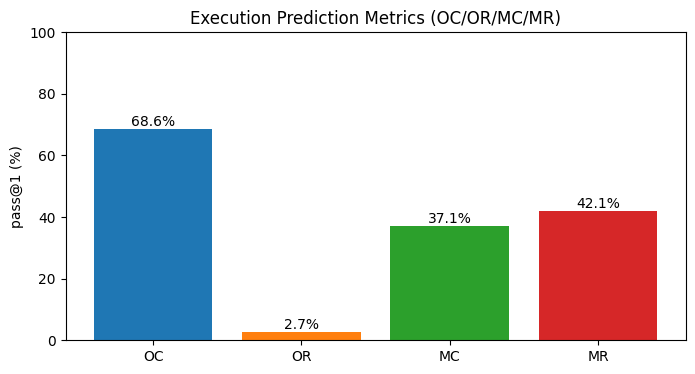

,Dataset,Problems Evaluated,Generations per Problem,OC pass@1,OR pass@1,MC pass@1,MR pass@1
0,LLM-List,104,5,68.59%,2.66%,37.12%,42.07%


In [8]:
# Plot execution prediction metrics
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'OC': metrics_summary.get('OC'),
    'OR': metrics_summary.get('OR'),
    'MC': metrics_summary.get('MC'),
    'MR': metrics_summary.get('MR'),
}
labels = list(metrics.keys())
values = [metrics[k] * 100 if metrics[k] is not None else None for k in labels]

plt.figure(figsize=(8, 4))
bars = plt.bar(labels, [v if v is not None else 0 for v in values], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for bar, val in zip(bars, values):
    if val is None:
        bar.set_alpha(0.3)
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 'N/A', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{val:.1f}%', ha='center', va='bottom')
plt.ylim(0, 100)
plt.ylabel('pass@1 (%)')
plt.title('Execution Prediction Metrics (OC/OR/MC/MR)')
plt.show()

# If plotting in a non-interactive environment, ensure figures display.
plt.close()

# Display raw summary alongside the plot
display(benchmark_table.style.format(formatters))


In [9]:
import json
import math
from datetime import datetime

if 'benchmark_summary' not in globals():
    raise RuntimeError('Run the benchmark cell first to produce metrics.')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"gpt_oss_20b_leetcode_benchmark_{timestamp}.json"


def _clean_nan(value):
    if value is None:
        return None
    if isinstance(value, float) and math.isnan(value):
        return None
    return value


payload = {
    "model": "gpt-oss-20b",
    "dataset": benchmark_summary["dataset"],
    "reasoning_effort": REASONING_EFFORT,
    "num_problems": benchmark_summary["problems_evaluated"],
    "num_generations": benchmark_summary["generations_per_problem"],
    "temperature": TEMPERATURE,
    "top_p": TOP_P,
    "seed": SEED,
    "skip_boolean_for_reversion": SKIP_BOOLEAN_FOR_REVERSION,
    "reversion_skipped_problems": benchmark_summary["reversion_skipped_problems"],
    "metrics": {k: _clean_nan(v) for k, v in metrics_summary.items()},
    "metrics_counts": metrics_counts,
    "benchmark_summary": {k: _clean_nan(v) for k, v in benchmark_summary.items()},
    "results": results,
}

if 'execution_choice_summary' in globals():
    payload['execution_choice_summary'] = {k: _clean_nan(v) for k, v in execution_choice_summary.items()}
    payload['execution_choice_counts'] = execution_choice_counts
    payload['execution_choice_results'] = execution_choice_results
    payload['execution_choice_config'] = {
        'num_problems': NUM_PROBLEMS_CHOICE,
        'start_index': START_INDEX_CHOICE,
        'runs_per_problem': NUM_RUNS_PER_PROBLEM,
        'reasoning_effort': REASONING_EFFORT_CHOICE,
        'max_new_tokens': MAX_NEW_TOKENS_CHOICE,
        'temperature': TEMPERATURE_CHOICE,
        'top_p': TOP_P_CHOICE,
        'seed': SEED_CHOICE,
        'skip_boolean_for_reversion': SKIP_BOOLEAN_FOR_REVERSION_CHOICE,
    }

with open(output_filename, "w") as f:
    json.dump(payload, f, indent=2)

print(f"✓ Saved evaluation summary to {output_filename}")

try:
    from google.colab import files
    files.download(output_filename)
except ImportError:
    print("(Optional) Run inside Colab to download the file automatically.")


✓ Saved evaluation summary to gpt_oss_20b_leetcode_benchmark_20251207_225340.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 8: Execution Choice Benchmark on DSL Dataset (Preference / Correctness / Reversion)

Run the paired-program experiment to measure program preference, correctness, and reversion with order swapping.

In [17]:
import random
import time
from typing import Optional
import pandas as pd

from tqdm.auto import tqdm

# Execution choice configuration
NUM_PROBLEMS_CHOICE = None         # Set to None to evaluate the full dataset
START_INDEX_CHOICE = 0
NUM_RUNS_PER_PROBLEM = 2          # Two runs per problem with swapped ordering
REASONING_EFFORT_CHOICE = "low"
MAX_NEW_TOKENS_CHOICE = 5000
TEMPERATURE_CHOICE = 0.6
TOP_P_CHOICE = 0.95
SEED_CHOICE = 123
SKIP_BOOLEAN_FOR_REVERSION_CHOICE = True
CASE_IDX_CHOICE = 0

if NUM_RUNS_PER_PROBLEM not in (1, 2):
    raise ValueError('NUM_RUNS_PER_PROBLEM must be 1 or 2 for the ordering swap protocol.')

torch.manual_seed(SEED_CHOICE)
random.seed(SEED_CHOICE)


def generate_choice_response(prompt: str, seed: int) -> dict:
    """Generate a model response for the execution choice prompt."""
    generator = torch.Generator(device=model.device)
    generator.manual_seed(seed)
    print("Prompt: ", prompt)
    messages = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
        reasoning_effort=REASONING_EFFORT_CHOICE,
    ).to(model.device)

    start_time = time.time()
    generation_kwargs = {
        "max_new_tokens": MAX_NEW_TOKENS_CHOICE,
        "do_sample": True,
        "temperature": TEMPERATURE_CHOICE,
        "top_p": TOP_P_CHOICE
    }

    pad_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
    if pad_id is not None:
        generation_kwargs["pad_token_id"] = pad_id

    output_ids = model.generate(**inputs, **generation_kwargs)
    latency = time.time() - start_time

    response = tokenizer.decode(
        output_ids[0][inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True,
    )
    print("response: ", response)

    return {
        "response": response,
        "latency_s": latency,
    }


if NUM_PROBLEMS_CHOICE is None:
    problem_indices_choice = list(range(len(dataset)))
else:
    stop_choice = min(len(dataset), START_INDEX_CHOICE + NUM_PROBLEMS_CHOICE)
    problem_indices_choice = list(range(START_INDEX_CHOICE, stop_choice))

if not problem_indices_choice:
    raise ValueError('No problems selected. Adjust START_INDEX_CHOICE / NUM_PROBLEMS_CHOICE.')

print(f"Evaluating execution choice on {len(problem_indices_choice)} problems with {NUM_RUNS_PER_PROBLEM} run(s) each.")
print(f"Reasoning effort: {REASONING_EFFORT_CHOICE}, temperature: {TEMPERATURE_CHOICE}, top_p: {TOP_P_CHOICE}")

execution_choice_counts = {
    'preference': {'original': 0, 'mutated': 0, 'total': 0},
    'OC': {'correct': 0, 'total': 0, 'reversion_correct': 0, 'reversion_total': 0},
    'MC': {'correct': 0, 'total': 0, 'reversion_correct': 0, 'reversion_total': 0},
    'invalid_runs': 0,
}

execution_choice_results = []
execution_choice_latencies = []
reversion_skip_count_choice = 0

orderings = [True, False]
selected_orderings = orderings[:NUM_RUNS_PER_PROBLEM]

for idx in tqdm(problem_indices_choice, desc='Execution choice'):
    sample = dataset[idx]
    num_cases = len(sample['inputs'])

    for case_idx in range(num_cases):
        original_output = str(sample['original_outputs'][case_idx])
        mutated_output  = str(sample['mutated_outputs'][case_idx])

        include_reversion = True
        if original_output == mutated_output:
            include_reversion = False
        if SKIP_BOOLEAN_FOR_REVERSION_CHOICE and (
            is_boolean_output(original_output) or is_boolean_output(mutated_output)
        ):
            include_reversion = False
            reversion_skip_count_choice += 1

        base_seed = SEED_CHOICE + idx * 1000 + case_idx * 10

        for run_offset, original_first in enumerate(selected_orderings):
            prompt, mapping = build_execution_choice_prompt(
                sample, original_first=original_first, case_idx=case_idx
            )
            generation = generate_choice_response(prompt, base_seed + run_offset)
            execution_choice_latencies.append(generation['latency_s'])

            run_record = {
                'problem_index': int(idx),
                'case_idx': int(case_idx),
                'problem_id': sample['id'],
                'function_name': parse_function_name(sample['header']),
                'run_index': run_offset,
                'original_first': original_first,
                'response': generation['response'],
                'latency_s': generation['latency_s'],
                'include_reversion': include_reversion,
                'chosen_program_letter': None,
                'chosen_program_type': None,
                'prediction': None,
                'correct_for_chosen_program': None,
                'reversion_for_other_program': None,
                'error': None,
            }

            try:
                parsed = parse_execution_choice_response(generation['response'])
            except ValueError as exc:
                run_record['error'] = str(exc)
                execution_choice_counts['invalid_runs'] += 1
                execution_choice_results.append(run_record)
                continue

            chosen_letter = str(parsed.get('chosen_program', '')).strip().upper()
            assertion_text = parsed.get('assertion', '')
            predicted_output = extract_output_from_assertion(assertion_text)
            chosen_type = mapping.get(chosen_letter)

            if chosen_type not in {'original', 'mutated'}:
                run_record['error'] = f"Unrecognized chosen program letter: {chosen_letter}"
                execution_choice_counts['invalid_runs'] += 1
                execution_choice_results.append(run_record)
                continue

            chosen_output = original_output if chosen_type == 'original' else mutated_output
            other_output  = mutated_output if chosen_type == 'original' else original_output

            is_correct, correctness_error = check_predicted_output(predicted_output, chosen_output)
            if include_reversion:
                is_reversion, reversion_error = check_predicted_output(predicted_output, other_output)
            else:
                is_reversion, reversion_error = None, None

            execution_choice_counts['preference']['total'] += 1
            if chosen_type == 'original':
                execution_choice_counts['preference']['original'] += 1
                bucket = execution_choice_counts['OC']
            else:
                execution_choice_counts['preference']['mutated'] += 1
                bucket = execution_choice_counts['MC']

            bucket['total'] += 1
            if is_correct:
                bucket['correct'] += 1
            if include_reversion:
                bucket['reversion_total'] += 1
                if is_reversion:
                    bucket['reversion_correct'] += 1

            run_record.update({
                'chosen_program_letter': chosen_letter,
                'chosen_program_type': chosen_type,
                'answer': predicted_output,
                'prediction': predicted_output,
                'correct_for_chosen_program': bool(is_correct),
                'reversion_for_other_program': bool(is_reversion) if include_reversion else None,
                'correctness_error': correctness_error,
                'reversion_error': reversion_error,
            })
            execution_choice_results.append(run_record)


def _safe_ratio(numerator: int, denominator: int) -> Optional[float]:
    return None if denominator == 0 else numerator / denominator


preference_total = execution_choice_counts['preference']['total']
preference_original_rate = _safe_ratio(
    execution_choice_counts['preference']['original'], preference_total
)
preference_mutated_rate = _safe_ratio(
    execution_choice_counts['preference']['mutated'], preference_total
)

oc_correct_rate = _safe_ratio(
    execution_choice_counts['OC']['correct'], execution_choice_counts['OC']['total']
)
or_reversion_rate = _safe_ratio(
    execution_choice_counts['OC']['reversion_correct'], execution_choice_counts['OC']['reversion_total']
)
mc_correct_rate = _safe_ratio(
    execution_choice_counts['MC']['correct'], execution_choice_counts['MC']['total']
)
mr_reversion_rate = _safe_ratio(
    execution_choice_counts['MC']['reversion_correct'], execution_choice_counts['MC']['reversion_total']
)

execution_choice_summary = {
    'dataset': 'LLM-List',
    'problems_evaluated': len(problem_indices_choice),
    'runs_per_problem': NUM_RUNS_PER_PROBLEM,
    'preference_original': preference_original_rate,
    'preference_mutated': preference_mutated_rate,
    'oc_correct': oc_correct_rate,
    'or_reversion': or_reversion_rate,
    'mc_correct': mc_correct_rate,
    'mr_reversion': mr_reversion_rate,
    'avg_latency_s': (
        sum(execution_choice_latencies) / len(execution_choice_latencies)
        if execution_choice_latencies else None
    ),
    'invalid_runs': execution_choice_counts['invalid_runs'],
    'reversion_skipped_problems': (
        reversion_skip_count_choice if SKIP_BOOLEAN_FOR_REVERSION_CHOICE else 0
    ),
}

execution_choice_table = pd.DataFrame([{
    'Dataset': 'LLM-List',
    'Problems Evaluated': execution_choice_summary['problems_evaluated'],
    'Runs per Problem': execution_choice_summary['runs_per_problem'],
    'Preference (Original)': execution_choice_summary['preference_original'],
    'OC Correct': execution_choice_summary['oc_correct'],
    'OR Reversion': execution_choice_summary['or_reversion'],
    'MC Correct': execution_choice_summary['mc_correct'],
    'MR Reversion': execution_choice_summary['mr_reversion'],
}])

choice_formatters = {
    'Preference (Original)': lambda v, _pd=pd: 'N/A' if _pd.isna(v) else f"{v:.2%}",
    'OC Correct': lambda v, _pd=pd: 'N/A' if _pd.isna(v) else f"{v:.2%}",
    'OR Reversion': lambda v, _pd=pd: 'N/A' if _pd.isna(v) else f"{v:.2%}",
    'MC Correct': lambda v, _pd=pd: 'N/A' if _pd.isna(v) else f"{v:.2%}",
    'MR Reversion': lambda v, _pd=pd: 'N/A' if _pd.isna(v) else f"{v:.2%}",
}

display(execution_choice_table.style.format(choice_formatters))

print('Preference counts:')
print(
    f"  Original: {execution_choice_counts['preference']['original']} / {preference_total}"
)
print(
    f"  Mutated: {execution_choice_counts['preference']['mutated']} / {preference_total}"
)
print(f"Invalid runs (no usable JSON response): {execution_choice_counts['invalid_runs']}")
if execution_choice_summary['avg_latency_s'] is not None:
    print(f"Average latency per run: {execution_choice_summary['avg_latency_s']:.2f}s")
else:
    print('Average latency per run: N/A')
if SKIP_BOOLEAN_FOR_REVERSION_CHOICE:
    print(
        f"Problems skipped for reversion metrics (boolean outputs): {reversion_skip_count_choice}"
    )


Evaluating execution choice on 104 problems with 2 run(s) each.
Reasoning effort: low, temperature: 0.6, top_p: 0.95


Execution choice:   0%|          | 0/104 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

Looking at programs A and B, the difference is in the expression for rest. Program A defines rest as s[1:].upper() while program B defines rest as s[1:].lower(). Program B looks similar to how one might implement the capitalize() function, so I will choose program B as I am more confident in reasoning about this program behavior.

Now, let's execute the code step by step:

1. The function performOperation is defined, which takes a single argument s.
2. The function is called with the argument 'hELLO', so within the function, s is initially 'hELLO'.
3. The variable first is defined as the upper case of the first character of s, which is 'H'.
4. The variable rest is defined as the lower case of s[1:], which is 'ello'.
5. The function returns first ('H') concatenated with rest ('ello').
6. The return value of the function is therefore 'Hello'.
[/THOUGHT]

{
  "chosen_program": "B",
  "assertion": "assert performOperation(s = \'hELLO\') =

<unknown>:1: SyntaxWarning: invalid escape sequence '\('


Streaming output truncated to the last 5000 lines.
  "chosen_program": "B",
  "assertion": "assert performOperation(s = \'hELLO\') == \'Hello\'"
}

# Question

[PROGRAM_A]
def pair_sums(lst):
    result = []
    length = len(lst)
    index = 0
    while index + 1 < length:
        left = lst[index]
        right = lst[index - 1]
        total = left + right
        result.append(total)
        index += 1
    return result
[/PROGRAM_A]

[PROGRAM_B]
def pair_sums(lst):
    result = []
    length = len(lst)
    index = 0
    while index + 1 < length:
        left = lst[index]
        right = lst[index + 1]
        total = left + right
        result.append(total)
        index += 1
    return result
[/PROGRAM_B]

[ASSERTION]
assert pair_sums([2, 3]) == ??
[/ASSERTION]
response:  {
  "chosen_program": "A",
  "assertion": "assert pair_sums([2, 3]) == [5]"
}

# Explanation

Let's analyze the programs and the assertion step by step:

Program A:

```python
def pair_sums(lst):
    result = []
 

This is a friendly reminder - the current text generation call has exceeded the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


response:  First, let's figure out which program I am more confident in reasoning about.

Looking at programs A and B, the difference is in the definition of the contains function. Program A checks if a value is not equal to the item, while program B checks if a value is equal to the item. Since the question does not provide any context to determine which comparison is more appropriate, I will choose program B as it is the most straightforward and aligns with the typical definition of the contains function.

Now, let's execute the code step by step:

1. The function intersection_ordered is defined, which takes two arguments: lst and other.
2. The function is called with the arguments [9, 8] and [1, 2], so within the function, lst is initially [9, 8] and other is initially [1, 2].
3. The function contains is defined, which takes two arguments: seq and item.
4. The function contains is called with arguments result and x. Since result is initially empty, it does not contain any item.
5. T

<unknown>:1: SyntaxWarning: invalid escape sequence '\['


Streaming output truncated to the last 5000 lines.
    return result
[/PROGRAM_A]

[PROGRAM_B]
def quick_sort(lst):
    n = len(lst)
    if n <= 1:
        return lst[:]
    pivot_index = n // 2
    pivot = lst[pivot_index]
    left = []
    equal = []
    right = []
    i = 1
    while i < n:
        v = lst[i]
        if v < pivot:
            left.append(v)
        elif v > pivot:
            right.append(v)
        else:
            equal.append(v)
        i += 1
    left_sorted = quick_sort(left) if len(left) > 1 else left[:]
    right_sorted = quick_sort(right) if len(right) > 1 else right[:]
    result = []
    result.extend(left_sorted)
    result.extend(equal)
    result.extend(right_sorted)
    return result
[/PROGRAM_B]

[ASSERTION]
assert quick_sort([5]) == ??
[/ASSERTION]
response:  From the given programs, both are implementations of the quick sort algorithm. However, the difference in the while loop of the programs is that in Program A, the loop starts from the first ind

,Dataset,Problems Evaluated,Runs per Problem,Preference (Original),OC Correct,OR Reversion,MC Correct,MR Reversion
0,LLM-List,104,2,64.78%,64.99%,7.20%,33.66%,49.23%


Preference counts:
  Original: 377 / 582
  Mutated: 205 / 582
Invalid runs (no usable JSON response): 42
Average latency per run: 14.79s
Problems skipped for reversion metrics (boolean outputs): 18


In [18]:
import json
import math
from datetime import datetime

if 'execution_choice_summary' not in globals():
    raise RuntimeError('Run the execution choice benchmark cell first to produce metrics.')

timestamp_choice = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename_choice = f"deepseek_coder_7b_llmlist_execution_choice_{timestamp_choice}.json"

def _clean_nan_choice(value):
    if value is None:
        return None
    if isinstance(value, float) and math.isnan(value):
        return None
    return value

# Metrics in OC/OR/MC/MR form
execution_choice_metrics = {
    "OC": execution_choice_summary["oc_correct"],
    "OR": execution_choice_summary["or_reversion"],
    "MC": execution_choice_summary["mc_correct"],
    "MR": execution_choice_summary["mr_reversion"],
}

# Metrics counts: map from your OC/MC buckets
execution_choice_metrics_counts = {
    "OC": {
        "success": execution_choice_counts["OC"]["correct"],
        "total": execution_choice_counts["OC"]["total"],
    },
    "OR": {
        "success": execution_choice_counts["OC"]["reversion_correct"],
        "total": execution_choice_counts["OC"]["reversion_total"],
    },
    "MC": {
        "success": execution_choice_counts["MC"]["correct"],
        "total": execution_choice_counts["MC"]["total"],
    },
    "MR": {
        "success": execution_choice_counts["MC"]["reversion_correct"],
        "total": execution_choice_counts["MC"]["reversion_total"],
    },
}

# Summary block, reusing the fields you actually have
benchmark_summary_choice = {
    "dataset": execution_choice_summary["dataset"],
    "problems_evaluated": execution_choice_summary["problems_evaluated"],
    "runs_per_problem": execution_choice_summary["runs_per_problem"],
    "oc_pass_at_1": execution_choice_summary["oc_correct"],
    "or_pass_at_1": execution_choice_summary["or_reversion"],
    "mc_pass_at_1": execution_choice_summary["mc_correct"],
    "mr_pass_at_1": execution_choice_summary["mr_reversion"],
    "avg_latency_s": execution_choice_summary["avg_latency_s"],
    "reversion_skipped_problems": execution_choice_summary["reversion_skipped_problems"],
    # extra choice-specific stats
    "preference_original": execution_choice_summary["preference_original"],
    "preference_mutated": execution_choice_summary["preference_mutated"],
    "invalid_runs": execution_choice_summary["invalid_runs"],
}

execution_choice_payload = {
    "model": "gpt-oss-20b",
    "dataset": execution_choice_summary["dataset"],
    "reasoning_effort": REASONING_EFFORT_CHOICE,
    "num_problems": execution_choice_summary["problems_evaluated"],
    "num_runs_per_problem": execution_choice_summary["runs_per_problem"],
    "temperature": TEMPERATURE_CHOICE,
    "top_p": TOP_P_CHOICE,
    "seed": SEED_CHOICE,
    "skip_boolean_for_reversion": SKIP_BOOLEAN_FOR_REVERSION_CHOICE,
    "reversion_skipped_problems": execution_choice_summary["reversion_skipped_problems"],
    "metrics": {k: _clean_nan_choice(v) for k, v in execution_choice_metrics.items()},
    "metrics_counts": {
        k: {
            "success": _clean_nan_choice(v["success"]),
            "total": _clean_nan_choice(v["total"]),
        }
        for k, v in execution_choice_metrics_counts.items()
    },
    "benchmark_summary": {
        k: _clean_nan_choice(v) for k, v in benchmark_summary_choice.items()
    },
}

# Include detailed per-run results
if "execution_choice_results" in globals():
    execution_choice_payload["results"] = execution_choice_results
else:
    execution_choice_payload["results"] = []

with open(output_filename_choice, "w") as f:
    json.dump(execution_choice_payload, f, indent=2)

print(f"✓ Saved execution choice summary to {output_filename_choice}")

try:
    from google.colab import files
    files.download(output_filename_choice)
except ImportError:
    print("(Optional) Run inside Colab to download the file automatically.")


✓ Saved execution choice summary to deepseek_coder_7b_llmlist_execution_choice_20251207_124540.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 9: Compare Reasoning Efforts (Optional)

Evaluate a small subset with different reasoning effort settings.

In [ ]:
# Compare low vs medium vs high reasoning
reasoning_levels = ["low", "medium", "high"]
comparison_results = {}

NUM_COMPARISON_SAMPLES = min(5, len(dataset['train']))
MAX_NEW_TOKENS = 1000

for reasoning_effort in reasoning_levels:
    print(f"
Testing reasoning_effort={reasoning_effort}...")
    correct = 0
    total_latency = 0

    for idx in range(NUM_COMPARISON_SAMPLES):
        sample = dataset['train'][idx]
        for case_index in range(TEST_CASES_PER_PROBLEM):
            prompt = build_execution_prediction_prompt(sample, case_index=case_index)
            messages = [
                {"role": "user", "content": prompt}
            ]

            inputs = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                return_tensors="pt",
                return_dict=True,
            ).to(model.device)

            start_time = time.time()
            generated = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS)
            latency = time.time() - start_time
            total_latency += latency

            response = tokenizer.decode(
                generated[0][inputs["input_ids"].shape[-1]:],
                skip_special_tokens=True
            )

            predicted_output = extract_answer_from_response(response)
            expected_output = sample['output'][case_index]

            is_correct, _ = check_predicted_output(predicted_output, expected_output)
            if is_correct:
                correct += 1

    total_cases = NUM_COMPARISON_SAMPLES * TEST_CASES_PER_PROBLEM
    comparison_results[reasoning_effort] = {
        "correct": correct,
        "pass@1": correct / total_cases,
        "avg_latency": total_latency / total_cases
    }

print("
" + "="*60)
print("REASONING EFFORT COMPARISON")
print("="*60)
print(f"{'Reasoning':<12} {'pass@1':<10} {'Avg Latency':<15}")
print("-" * 60)
for level, stats in comparison_results.items():
    print(f"{level:<12} {stats['pass@1']*100:>6.1f}%   {stats['avg_latency']:>10.2f}s")
print("="*60)


## Next Steps

1. **Increase NUM_SAMPLES** to evaluate on more problems
2. **Try different reasoning_effort** levels
3. **Compare with other models** (DeepSeek-R1, GPT-4o, etc.)
4. **Analyze error patterns** to understand model weaknesses

---

**Note**: To run on full dataset (347 samples), expect ~1-2 hours on free Colab.